In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Input, MultiHeadAttention, Dense
from keras.models import Model
from training.lib.layers import ForexPrep, FloatEmbedding, PositionalEncoding

import os


In [2]:
DATA_PATH = os.path.abspath("training/Data/daily_csv.csv")
COUNTRY = "United Kingdom"
AVERAGING_GAP = 7
SEQ_LEN = 128 + AVERAGING_GAP
BATCH_SIZE = 64
EPOCHS = 15
HEADS = 6
EMBEDDING_UNITS = 64
FEED_FORWARD_DENSE_LAYERS = [30, 10]
SPLIT_RATIO = 0.33


In [3]:
def load_data(path=DATA_PATH, country=COUNTRY) -> np.ndarray:
	df = pd.read_csv(path)
	df = df.dropna()
	df = df[df["Country"] == country]
	return df["Value"].to_numpy()


In [4]:
def create_model(seq_len=SEQ_LEN, heads=HEADS, averaging_gap=AVERAGING_GAP, embedding_units=EMBEDDING_UNITS, ff_dense_layers=FEED_FORWARD_DENSE_LAYERS) -> Model:
	input0 = Input(shape=(seq_len, 1))
	prep = ForexPrep(average_gap=averaging_gap)(input0)
	embedding = FloatEmbedding(embedding_units)(prep)
	positional_encoding = PositionalEncoding()(embedding)
	multi_head = MultiHeadAttention(heads, positional_encoding.shape[1])(positional_encoding, positional_encoding)
	ff_dense = Dense(ff_dense_layers[0])(multi_head)
	for units in ff_dense_layers[1:]:
		ff_dense = Dense(units)(ff_dense)
	shrink_dense = Dense(1)(ff_dense)
	reshaped = tf.reshape(shrink_dense, (-1, shrink_dense.shape[1]))
	ff_dense = Dense(ff_dense_layers[0])(reshaped)
	for units in ff_dense_layers[1:]:
		ff_dense = Dense(units)(ff_dense)
	output = tf.reshape(Dense(1)(ff_dense), (-1,))
	
	return Model(inputs=input0, outputs=output)


In [5]:
def prepare_data(data: np.ndarray, seq_len=SEQ_LEN):
	if len(data.shape) == 2:
		data = data.reshape((-1,))
	
	data_len = data.shape[0] - seq_len
	
	X = np.zeros((data_len, seq_len))
	y = np.zeros((data_len,))
	
	for i in range(data_len):
		X[i] = data[i:i+seq_len]
		y[i] = data[i+seq_len]
	
	return X, y


In [6]:
def split_data(X, y, split_ratio=SPLIT_RATIO):
	test_size = int(split_ratio*X.shape[0])
	return X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
	

In [7]:
data = load_data()
X, y = prepare_data(data)
X_train, X_test, y_train, y_test = split_data(X, y)


In [8]:
model = create_model()
model.compile(optimizer="adam", loss="mse")

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 135, 1)]     0                                            
__________________________________________________________________________________________________
forex_prep (ForexPrep)          (None, 128, 2)       0           input_1[0][0]                    
__________________________________________________________________________________________________
float_embedding (FloatEmbedding (None, 128, 64)      192         forex_prep[0][0]                 
__________________________________________________________________________________________________
positional_encoding (Positional (None, 128, 64)      0           float_embedding[0][0]            
______________________________________________________________________________________________

In [105]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/15


ValueError: in user code:

    /home/abrehamatlaw/Projects/Personal_Projects/Mini_Projects/ForexTrader/Predictor/venv/lib64/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/abrehamatlaw/Projects/Personal_Projects/Mini_Projects/ForexTrader/Predictor/venv/lib64/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/abrehamatlaw/Projects/Personal_Projects/Mini_Projects/ForexTrader/Predictor/venv/lib64/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/abrehamatlaw/Projects/Personal_Projects/Mini_Projects/ForexTrader/Predictor/venv/lib64/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/abrehamatlaw/Projects/Personal_Projects/Mini_Projects/ForexTrader/Predictor/venv/lib64/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/abrehamatlaw/Projects/Personal_Projects/Mini_Projects/ForexTrader/Predictor/venv/lib64/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/abrehamatlaw/Projects/Personal_Projects/Mini_Projects/ForexTrader/Predictor/venv/lib64/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/abrehamatlaw/Projects/Personal_Projects/Mini_Projects/ForexTrader/Predictor/venv/lib64/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/abrehamatlaw/Projects/Personal_Projects/Mini_Projects/ForexTrader/Predictor/venv/lib64/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_7: expected shape=(None, 135, 1), found shape=(None, 59)


In [74]:
model.evaluate(X_test, y_test)

  1/121 [..............................] - ETA: 27s - loss: 3.4618e-05

  4/121 [..............................] - ETA: 2s - loss: 3.6681e-05 

  7/121 [>.............................] - ETA: 2s - loss: 4.4864e-05

 10/121 [=>............................] - ETA: 2s - loss: 5.3598e-05

 13/121 [==>...........................] - ETA: 2s - loss: 6.9825e-05

 17/121 [===>..........................] - ETA: 1s - loss: 6.9504e-05

 21/121 [====>.........................] - ETA: 1s - loss: 6.8428e-05

 25/121 [=====>........................] - ETA: 1s - loss: 6.5358e-05

 29/121 [======>.......................] - ETA: 1s - loss: 6.4486e-05

 33/121 [=======>......................] - ETA: 1s - loss: 6.3112e-05

 36/121 [=======>......................] - ETA: 1s - loss: 6.6328e-05

 40/121 [========>.....................] - ETA: 1s - loss: 6.8002e-05

 44/121 [=========>....................] - ETA: 1s - loss: 6.7153e-05

 48/121 [==========>...................] - ETA: 1s - loss: 6.4955e-05

 51/121 [===========>..................] - ETA: 1s - loss: 1.4542e-04

 55/121 [============>.................] - ETA: 1s - loss: 1.7268e-04

 59/121 [=============>................] - ETA: 1s - loss: 1.6566e-04

 63/121 [==============>...............] - ETA: 0s - loss: 1.6159e-04

 66/121 [===============>..............] - ETA: 0s - loss: 1.5748e-04

 69/121 [================>.............] - ETA: 0s - loss: 1.5291e-04

 72/121 [================>.............] - ETA: 0s - loss: 1.4927e-04

 76/121 [=================>............] - ETA: 0s - loss: 1.4457e-04

 80/121 [==================>...........] - ETA: 0s - loss: 1.3966e-04

 84/121 [===================>..........] - ETA: 0s - loss: 1.3524e-04

 88/121 [====================>.........] - ETA: 0s - loss: 1.3162e-04

 92/121 [=====================>........] - ETA: 0s - loss: 1.2954e-04

 96/121 [======================>.......] - ETA: 0s - loss: 1.2771e-04

 99/121 [=======================>......] - ETA: 0s - loss: 1.2486e-04

103/121 [========================>.....] - ETA: 0s - loss: 1.2224e-04

106/121 [=========================>....] - ETA: 0s - loss: 1.2070e-04

110/121 [==========================>...] - ETA: 0s - loss: 1.3441e-04

114/121 [===========================>..] - ETA: 0s - loss: 1.4998e-04

118/121 [============================>.] - ETA: 0s - loss: 1.4680e-04

121/121 [==============================] - 2s 16ms/step - loss: 1.4437e-04


0.00014437444042414427

In [81]:
X_predict = model.predict(X_train)

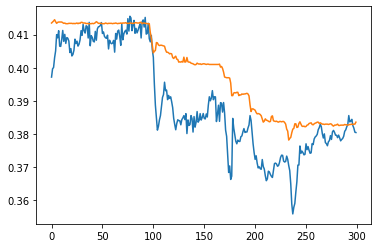

In [90]:
plt.plot(X_predict[:300])
plt.plot(y_train[:300])